# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import os

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow import keras
from keras.callbacks import EarlyStopping

# Load data

In [ ]:
generation1 = pd.read_csv('/content/drive/MyDrive/240_Project/Plant_1_Generation_Data.csv')
weather1 = pd.read_csv('/content/drive/MyDrive/240_Project/Plant_1_Weather_Sensor_Data.csv')
generation1['DATE_TIME'] = pd.to_datetime(generation1['DATE_TIME'], dayfirst=True)
weather1['DATE_TIME'] = pd.to_datetime(weather1['DATE_TIME'], dayfirst=True)


In [ ]:
generation1

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0
1,2020-05-15 00:00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0
2,2020-05-15 00:00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0
3,2020-05-15 00:00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0
4,2020-05-15 00:00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0
...,...,...,...,...,...,...,...
68773,2020-06-17 23:45:00,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0
68774,2020-06-17 23:45:00,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0
68775,2020-06-17 23:45:00,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0
68776,2020-06-17 23:45:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0


In [ ]:
inverters = list(generation1['SOURCE_KEY'].unique())
print(f"total number of inverters {len(inverters)}")


total number of inverters 22


# Inverter-level anomally detection

In [ ]:
inverters[0]

'1BY6WEcLGh8j5v7'

In [ ]:
inv_1 = generation1[generation1['SOURCE_KEY']==inverters[0]]
# Keep only datetime stamps that are common to both weather and inverter dataframes
mask = ((weather1['DATE_TIME'] >= min(inv_1["DATE_TIME"])) & (weather1['DATE_TIME'] <= max(inv_1["DATE_TIME"])))
weather_filtered = weather1.loc[mask]

In [ ]:
weather_filtered.shape

(3182, 6)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=inv_1["DATE_TIME"], y=inv_1["AC_POWER"],
                    mode='lines',
                    name='AC Power'))

fig.add_trace(go.Scatter(x=weather_filtered["DATE_TIME"], y=weather_filtered["IRRADIATION"],
                    mode='lines',
                    name='Irradiation',
                    yaxis='y2'))

fig.update_layout(title_text="Irradiation vs AC POWER",
                  yaxis1=dict(title="AC Power in kW",
                              side='left'),
                  yaxis2=dict(title="Irradiation index",
                              side='right',
                              anchor="x",
                              overlaying="y"
                             ))

fig.show()

Graph observations:
**Anomalies** can be observed in the production data for **June 7th** and **June 14th**, which deviate from the expected linear relationship between energy production and irradiation.

In [ ]:
df = inv_1.merge(weather_filtered, on="DATE_TIME", how='left')
df = df[['DATE_TIME', 'DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
df

,DATE_TIME,DC_POWER,AC_POWER,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,0.0,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,0.0,0.0,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,0.0,0.0,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,0.0,0.0,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,0.0,0.0,24.621525,22.165423,0.0
...,...,...,...,...,...,...
3149,2020-06-17 22:45:00,0.0,0.0,22.150570,21.480377,0.0
3150,2020-06-17 23:00:00,0.0,0.0,22.129816,21.389024,0.0
3151,2020-06-17 23:15:00,0.0,0.0,22.008275,20.709211,0.0
3152,2020-06-17 23:30:00,0.0,0.0,21.969495,20.734963,0.0


# Regular LSTM

In [ ]:
df = df[["DATE_TIME", "DC_POWER", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]]
df_timestamp = df[["DATE_TIME"]]
df_ = df[["MODULE_TEMPERATURE", "IRRADIATION", "DC_POWER"]]

In [ ]:
# Features for modeling, with target=DC_POWER
df_.describe()

,MODULE_TEMPERATURE,IRRADIATION,DC_POWER
count,3154.000000,3154.000000,3154.000000
mean,31.182856,0.230310,2873.720981
std,12.275731,0.301417,3761.145773
min,18.140415,0.000000,0.000000
25%,21.134045,0.000000,0.000000
50%,24.807481,0.028563,302.955357
75%,41.449680,0.451723,5775.531250
max,65.545714,1.221652,13335.142860


In [ ]:
train_prp = .6
train = df_.loc[:df_.shape[0]*train_prp]
test = df_.loc[df_.shape[0]*train_prp:]

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1893, 3)
X_test shape: (1261, 3)


In [ ]:
# Predict 4 timesteps into the future. Since each timestep is equal to a 15-min interval, we are predicting hourly DC_POWER generation
X = []
Y = []
T = 4

In [ ]:
#Prepares input data for a LSTM, with shape (samples, timestep, features)
for i in range(T, X_train.shape[0]):
  x = X_train[i-T:i,:]
  X.append(x)
  y = X_train[i,:]
  Y.append(y)

In [ ]:
X,Y=np.array(X),np.array(Y)

In [ ]:
X.shape

(1889, 4, 3)

In [ ]:
def lstm_model():
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularization
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularization
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularization
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularization
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = X.shape[2]))
    return model

In [ ]:
'''from keras.regularizers import l1
from keras.initializers import glorot_normal

def lstm_model():
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X.shape[1], X.shape[2]),
                   kernel_regularizer=l1(0.01), kernel_initializer=glorot_normal()))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True,
                   kernel_regularizer=l1(0.01), kernel_initializer=glorot_normal()))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True,
                   kernel_regularizer=l1(0.01), kernel_initializer=glorot_normal()))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50,
                   kernel_regularizer=l1(0.01), kernel_initializer=glorot_normal()))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = X.shape[2], kernel_initializer=glorot_normal()))
    return model'''


In [ ]:
model = lstm_model()
opt = keras.optimizers.Adam(learning_rate=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=20)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_220 (LSTM)             (None, 4, 50)             10800     
                                                                 
 dropout_176 (Dropout)       (None, 4, 50)             0         
                                                                 
 lstm_221 (LSTM)             (None, 4, 50)             20200     
                                                                 
 dropout_177 (Dropout)       (None, 4, 50)             0         
                                                                 
 lstm_222 (LSTM)             (None, 4, 50)             20200     
                                                                 
 dropout_178 (Dropout)       (None, 4, 50)             0         
                                                                 
 lstm_223 (LSTM)             (None, 50)              

In [ ]:
epochs = 100
batch = 16
history = model.fit(X, Y, epochs=epochs, batch_size=batch, validation_split=.1, callbacks=[early_stop], verbose=1).history


Epoch 1/100
107/107 [==============================] - 17s 44ms/step - loss: 0.0353 - val_loss: 0.0190
Epoch 2/100
107/107 [==============================] - 3s 31ms/step - loss: 0.0166 - val_loss: 0.0104
Epoch 3/100
107/107 [==============================] - 2s 21ms/step - loss: 0.0149 - val_loss: 0.0102
Epoch 4/100
107/107 [==============================] - 2s 22ms/step - loss: 0.0135 - val_loss: 0.0096
Epoch 5/100
107/107 [==============================] - 2s 23ms/step - loss: 0.0126 - val_loss: 0.0099
Epoch 6/100
107/107 [==============================] - 3s 28ms/step - loss: 0.0111 - val_loss: 0.0123
Epoch 7/100
107/107 [==============================] - 4s 37ms/step - loss: 0.0116 - val_loss: 0.0079
Epoch 8/100
107/107 [==============================] - 2s 23ms/step - loss: 0.0099 - val_loss: 0.0072
Epoch 9/100
107/107 [==============================] - 2s 20ms/step - loss: 0.0093 - val_loss: 0.0070
Epoch 10/100
107/107 [==============================] - 2s 21ms/step - loss: 0.00

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=[x for x in range(len(history['loss']))], y=history['loss'],
                    mode='lines',
                    name='train loss'))

fig.add_trace(go.Scatter(x=[x for x in range(len(history['val_loss']))], y=history['val_loss'],
                    mode='lines',
                    name='validation loss'))

fig.update_layout(title="LSTM Loss",
                  yaxis=dict(title="Loss"),
                  xaxis=dict(title="Epoch"))

fig.show()

In [ ]:
Xt = []
Yt = []
T = 4

In [ ]:
for i in range(T, X_test.shape[0]):
  x = X_test[i-T:i,:]
  Xt.append(x)
  y = X_test[i,:]
  Yt.append(y)

In [ ]:
Xt,Yt=np.array(Xt),np.array(Yt)

In [ ]:
X_pred = model.predict(Xt)
X_pred = scaler.inverse_transform(X_pred)
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = testind.index

40/40 [==============================] - 0s 9ms/step


In [ ]:
X_pred.describe()

,MODULE_TEMPERATURE,IRRADIATION,DC_POWER
count,1257.000000,1257.000000,1257.000000
mean,31.267714,0.230684,2948.857910
std,12.231557,0.278660,3534.792236
min,19.181751,-0.009546,-109.467659
25%,21.298386,0.013310,167.580734
50%,23.765064,0.024191,315.330505
75%,42.634369,0.476501,6125.574219
max,59.194637,0.907820,11335.189453


In [ ]:
scores = X_pred
scores['datetime'] = df_timestamp.loc[1893:]
scores['real DC'] = test1[['DC_POWER']]
scores["loss_mae"] = (scores['real DC'] - scores['DC_POWER']).abs()

In [ ]:
'''# 1.5 IQR way
Q1 = scores['loss_mae'].quantile(0.25)
Q3 = scores['loss_mae'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
outliers = scores[(scores['loss_mae'] < lower_bound) | (scores['loss_mae'] > upper_bound)]'''

In [ ]:
# Three sigma way
mean = scores['loss_mae'].mean()
std = scores['loss_mae'].std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std
scores['Threshold'] = upper_bound
scores['Anomaly'] = np.where((scores['loss_mae'] < lower_bound) | (scores['loss_mae'] > upper_bound), 1, 0)

In [ ]:
scores.head()

,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,datetime,real DC,loss_mae,Threshold,Anomaly
1897,21.435823,0.013688,171.878418,2020-06-04 21:15:00,0.0,171.878418,4250.736623,0
1898,21.373669,0.013341,167.661407,2020-06-04 21:30:00,0.0,167.661407,4250.736623,0
1899,21.280876,0.013166,165.698959,2020-06-04 21:45:00,0.0,165.698959,4250.736623,0
1900,21.166290,0.013091,165.009445,2020-06-04 22:00:00,0.0,165.009445,4250.736623,0
1901,21.078861,0.012901,162.833969,2020-06-04 22:15:00,0.0,162.833969,4250.736623,0


In [ ]:
fig = go.Figure(data=[go.Histogram(x=scores['loss_mae'])])
fig.update_layout(title="Error distribution",
                 xaxis=dict(title="Error delta between predicted and real data [DC Power]"),
                 yaxis=dict(title="Data point counts"))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=scores['datetime'],
                         y=scores['loss_mae'],
                         name="Loss"))
fig.add_trace(go.Scatter(x=scores['datetime'],
                         y=scores['Threshold'],
                         name="Threshold"))

fig.update_layout(title="Error Timeseries and Threshold",
                 xaxis=dict(title="DateTime"),
                 yaxis=dict(title="Loss"))
fig.show()

In [ ]:
scores['Anomaly'].value_counts()

0    1228
1      29
Name: Anomaly, dtype: int64

In [ ]:
anomalies = scores[scores['Anomaly'] == 1][['real DC']]
anomalies = anomalies.rename(columns={'real DC':'anomalies'})
scores = scores.merge(anomalies, left_index=True, right_index=True, how='left')

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=scores["datetime"], y=scores["real DC"],
                    mode='lines',
                    name='DC Power'))

fig.add_trace(go.Scatter(x=scores["datetime"], y=scores["anomalies"],
                    name='Anomaly',
                    mode='markers',
                    marker=dict(color="red",
                                size=11,
                                line=dict(color="red",
                                          width=2))))

fig.update_layout(title_text="Anomalies Detected LSTM")

fig.show()

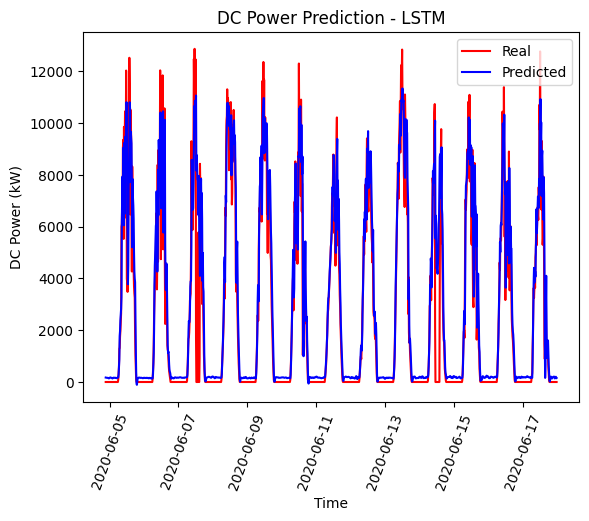

In [ ]:
# Visualize prediction results
plt.plot(scores['datetime'],scores['real DC'], color = 'red', label = 'Real')
plt.plot(scores['datetime'],scores['DC_POWER'], color = 'blue', label = 'Predicted')
plt.title('DC Power Prediction - LSTM')
plt.xticks(rotation=70)
plt.xlabel('Time')
plt.ylabel('DC Power (kW)')
plt.legend()
plt.show()

# MLP with LSTM Encoder

In [ ]:
# Predict T=1 timestep into the future, or one 15-min interval into the future
X = []
Y = []
T = 1

In [ ]:
for i in range(T, X_train.shape[0]):
  x = X_train[i-T:i,:]
  X.append(x)
  y = X_train[i,:]
  Y.append(y)

In [ ]:
X,Y=np.array(X),np.array(Y)

In [ ]:
X.shape

(1892, 1, 3)

In [ ]:
def autoencoder_model():
    model = Sequential()

    # Encoder
    model.add(LSTM(units = 16, return_sequences = True, kernel_regularizer=regularizers.l2(0.00), input_shape = (X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 4, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 1))
    model.add(Dropout(0.2))
    model.add(RepeatVector(X.shape[1]))

    # Decoder
    model.add(LSTM(units = 4, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 8, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 16, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(units = X.shape[2])))
    return model

In [ ]:
model = autoencoder_model()
early_stop = EarlyStopping(monitor='val_loss', patience=20)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_199 (LSTM)             (None, 1, 16)             1280      
                                                                 
 dropout_170 (Dropout)       (None, 1, 16)             0         
                                                                 
 lstm_200 (LSTM)             (None, 1, 4)              336       
                                                                 
 dropout_171 (Dropout)       (None, 1, 4)              0         
                                                                 
 lstm_201 (LSTM)             (None, 1)                 24        
                                                                 
 dropout_172 (Dropout)       (None, 1)                 0         
                                                                 
 repeat_vector_15 (RepeatVec  (None, 1, 1)           

In [ ]:
epochs = 100
batch = 8
history = model.fit(X, Y, epochs=epochs, batch_size=batch, validation_split=.1, callbacks=[early_stop], verbose=1).history


Epoch 1/100
213/213 [==============================] - 21s 35ms/step - loss: 0.1316 - val_loss: 0.1145
Epoch 2/100
213/213 [==============================] - 3s 13ms/step - loss: 0.1146 - val_loss: 0.0987
Epoch 3/100
213/213 [==============================] - 3s 12ms/step - loss: 0.0986 - val_loss: 0.0857
Epoch 4/100
213/213 [==============================] - 3s 13ms/step - loss: 0.0872 - val_loss: 0.0782
Epoch 5/100
213/213 [==============================] - 3s 13ms/step - loss: 0.0822 - val_loss: 0.0757
Epoch 6/100
213/213 [==============================] - 3s 16ms/step - loss: 0.0802 - val_loss: 0.0749
Epoch 7/100
213/213 [==============================] - 3s 13ms/step - loss: 0.0800 - val_loss: 0.0746
Epoch 8/100
213/213 [==============================] - 3s 13ms/step - loss: 0.0795 - val_loss: 0.0744
Epoch 9/100
213/213 [==============================] - 3s 12ms/step - loss: 0.0797 - val_loss: 0.0743
Epoch 10/100
213/213 [==============================] - 6s 30ms/step - loss: 0.07

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=[x for x in range(len(history['loss']))], y=history['loss'],
                    mode='lines',
                    name='train loss'))

fig.add_trace(go.Scatter(x=[x for x in range(len(history['val_loss']))], y=history['val_loss'],
                    mode='lines',
                    name='validation loss'))

fig.update_layout(title="LSTM Autoencoder Loss",
                  yaxis=dict(title="Loss"),
                  xaxis=dict(title="Epoch"))

fig.show()

In [ ]:
# Get only the LSTM encoder
encoder = Model(inputs=model.inputs, outputs=model.layers[4].output)

In [ ]:
train_encoded = encoder.predict(X)

60/60 [==============================] - 1s 2ms/step


In [ ]:
train_encoded.shape

(1892, 1)

In [ ]:
# Drop first row of train data
train1 = train.iloc[1:]
# Add encoded train data to the train dataframe
train1['encoded'] = train_encoded

<ipython-input-772-ab3e35260f0e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
train1.head(5)

,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,encoded
1,22.761668,0.0,0.0,-0.076696
2,22.592306,0.0,0.0,-0.076830
3,22.360852,0.0,0.0,-0.077067
4,22.165423,0.0,0.0,-0.077387
5,21.968571,0.0,0.0,-0.077655


In [ ]:
# Set target variable
Y1 = train1[['DC_POWER']]

In [ ]:
# Set features for model training
X1 = train1[['MODULE_TEMPERATURE', 'IRRADIATION', 'encoded']]

In [ ]:
X1.shape

(1892, 3)

In [ ]:
def mlp_model():
    model = Sequential()
    model.add(Dense(512, kernel_initializer='he_uniform', activation='relu', input_shape=(X1.shape[1],)))
    model.add(Dense(256, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(128, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(1))
    return model


In [ ]:
model = mlp_model()
opt = keras.optimizers.Adam(learning_rate=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=20)
model.compile(optimizer=opt, loss='mae')
model.summary()

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 512)               2048      
                                                                 
 dense_133 (Dense)           (None, 256)               131328    
                                                                 
 dense_134 (Dense)           (None, 128)               32896     
                                                                 
 dense_135 (Dense)           (None, 64)                8256      
                                                                 
 dense_136 (Dense)           (None, 32)                2080      
                                                                 
 dense_137 (Dense)           (None, 1)                 33        
                                                                 
Total params: 176,641
Trainable params: 176,641
Non-t

In [ ]:
epochs = 100
batch = 16
history = model.fit(X1, Y1, epochs=epochs, batch_size=batch, validation_split=.1, callbacks=[early_stop], verbose=1).history


Epoch 1/100
107/107 [==============================] - 2s 10ms/step - loss: 2876.2871 - val_loss: 2779.1650
Epoch 2/100
107/107 [==============================] - 1s 10ms/step - loss: 2412.2234 - val_loss: 2370.9895
Epoch 3/100
107/107 [==============================] - 1s 11ms/step - loss: 2347.5100 - val_loss: 2387.8201
Epoch 4/100
107/107 [==============================] - 1s 11ms/step - loss: 2337.1125 - val_loss: 2372.3218
Epoch 5/100
107/107 [==============================] - 1s 9ms/step - loss: 2339.8242 - val_loss: 2376.3464
Epoch 6/100
107/107 [==============================] - 1s 6ms/step - loss: 2336.8069 - val_loss: 2373.6660
Epoch 7/100
107/107 [==============================] - 1s 7ms/step - loss: 2329.1086 - val_loss: 2372.8271
Epoch 8/100
107/107 [==============================] - 1s 6ms/step - loss: 2330.3218 - val_loss: 2362.5688
Epoch 9/100
107/107 [==============================] - 1s 6ms/step - loss: 2326.1619 - val_loss: 2362.6443
Epoch 10/100
107/107 [===========

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=[x for x in range(len(history['loss']))], y=history['loss'],
                    mode='lines',
                    name='train loss'))

fig.add_trace(go.Scatter(x=[x for x in range(len(history['val_loss']))], y=history['val_loss'],
                    mode='lines',
                    name='validation loss'))

fig.update_layout(title="MLP with LSTM Encoder Loss",
                  yaxis=dict(title="Loss"),
                  xaxis=dict(title="Epoch"))

fig.show()

In [ ]:
train_preds = model.predict(X1)

60/60 [==============================] - 0s 2ms/step


In [ ]:
train_preds = pd.DataFrame(train_preds)

In [ ]:
train1['train_preds'] = train_preds

<ipython-input-786-75dfbf5d43ba>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
train1.describe()

,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,encoded,train_preds
count,1892.000000,1892.000000,1892.000000,1892.000000,1891.000000
mean,32.222603,0.241510,3067.929445,0.074025,2928.169189
std,12.921477,0.310918,3907.282246,0.191355,3812.310547
min,18.492340,0.000000,0.000000,-0.082220,-10.625347
25%,21.356274,0.000000,0.000000,-0.078597,-6.167967
50%,25.528864,0.036339,463.475000,-0.065664,89.754875
75%,43.468281,0.478535,6197.308036,0.288766,6211.086426
max,65.545714,1.151102,13335.142860,0.417773,12790.876953


In [ ]:
Xtt = []
Ytt = []
T = 1

In [ ]:
for i in range(T, X_test.shape[0]):
  x = X_test[i-T:i,:]
  Xtt.append(x)
  y = X_test[i,:]
  Ytt.append(y)

In [ ]:
Xtt,Ytt=np.array(Xtt),np.array(Ytt)

In [ ]:
Xtt.shape

(1260, 1, 3)

In [ ]:
test_encoded = encoder.predict(Xtt)

40/40 [==============================] - 0s 2ms/step


In [ ]:
# Drop first row of test data
test1 = test.iloc[1:]
# Add encoded test data to test dataframe
test1['encoded'] = test_encoded

<ipython-input-793-43d48002d86e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
test1.head(5)

,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,encoded
1894,21.246926,0.0,0.0,-0.078892
1895,21.202568,0.0,0.0,-0.078877
1896,20.969898,0.0,0.0,-0.078935
1897,20.891598,0.0,0.0,-0.079235
1898,20.771162,0.0,0.0,-0.079335


In [ ]:
# Set target variable
Y2 = test1[['DC_POWER']]

In [ ]:
# Set features for model prediction
X2 = test1[['MODULE_TEMPERATURE', 'IRRADIATION', 'encoded']]

In [ ]:
test_preds = model.predict(X2)

40/40 [==============================] - 0s 2ms/step


In [ ]:
# Add the predictions to the test dataframe
test1['test_preds'] = test_preds

<ipython-input-799-d3b71f746c68>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
test1.describe()

,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,encoded,test_preds
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000
mean,29.636087,0.213857,2586.661481,0.053857,2482.355469
std,11.066219,0.285984,3513.470837,0.177351,3405.771729
min,18.140415,0.000000,0.000000,-0.082616,-11.171884
25%,20.840490,0.000000,0.000000,-0.079303,-6.996704
50%,23.130767,0.015325,60.857143,-0.073720,-0.761681
75%,38.815374,0.424359,5203.142857,0.233261,5220.821655
max,60.757050,1.221652,12864.285710,0.414855,12779.170898


In [ ]:
scores = test1
scores['datetime'] = df_timestamp.loc[630:]
scores['real DC'] = test1['DC_POWER']
scores["loss_mae"] = (scores['real DC'] - scores['test_preds']).abs()

In [ ]:
# Three sigma way
mean = scores['loss_mae'].mean()
std = scores['loss_mae'].std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std
scores['Threshold'] = upper_bound
scores['Anomaly'] = np.where((scores['loss_mae'] < lower_bound) | (scores['loss_mae'] > upper_bound), 1, 0)

In [ ]:
scores.describe()

,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,encoded,test_preds,real DC,loss_mae,Threshold,Anomaly
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03,1260.000000
mean,29.636087,0.213857,2586.661481,0.053857,2482.355469,2586.661481,514.579892,4.054549e+03,0.018254
std,11.066219,0.285984,3513.470837,0.177351,3405.771729,3513.470837,1179.989851,9.098558e-13,0.133922
min,18.140415,0.000000,0.000000,-0.082616,-11.171884,0.000000,0.341344,4.054549e+03,0.000000
25%,20.840490,0.000000,0.000000,-0.079303,-6.996704,0.000000,7.089430,4.054549e+03,0.000000
50%,23.130767,0.015325,60.857143,-0.073720,-0.761681,60.857143,48.149899,4.054549e+03,0.000000
75%,38.815374,0.424359,5203.142857,0.233261,5220.821655,5203.142857,731.254900,4.054549e+03,0.000000
max,60.757050,1.221652,12864.285710,0.414855,12779.170898,12864.285710,12779.170898,4.054549e+03,1.000000


In [ ]:
fig = go.Figure(data=[go.Histogram(x=scores['loss_mae'])])
fig.update_layout(title="Error distribution",
                 xaxis=dict(title="Error delta between predicted and real data [DC Power]"),
                 yaxis=dict(title="Data point counts"))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=scores['datetime'],
                         y=scores['loss_mae'],
                         name="Loss"))
fig.add_trace(go.Scatter(x=scores['datetime'],
                         y=scores['Threshold'],
                         name="Threshold"))

fig.update_layout(title="Error Timeseries and Threshold",
                 xaxis=dict(title="DateTime"),
                 yaxis=dict(title="Loss"))
fig.show()

In [ ]:
scores['Anomaly'].value_counts()

0    1237
1      23
Name: Anomaly, dtype: int64

In [ ]:
anomalies = scores[scores['Anomaly'] == 1][['real DC']]
anomalies = anomalies.rename(columns={'real DC':'anomalies'})
scores = scores.merge(anomalies, left_index=True, right_index=True, how='left')

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=scores["datetime"], y=scores["real DC"],
                    mode='lines',
                    name='DC Power'))

fig.add_trace(go.Scatter(x=scores["datetime"], y=scores["anomalies"],
                    name='Anomaly',
                    mode='markers',
                    marker=dict(color="red",
                                size=11,
                                line=dict(color="red",
                                          width=2))))

fig.update_layout(title_text="Anomalies Detected MLP with LSTM Encoder")

fig.show()

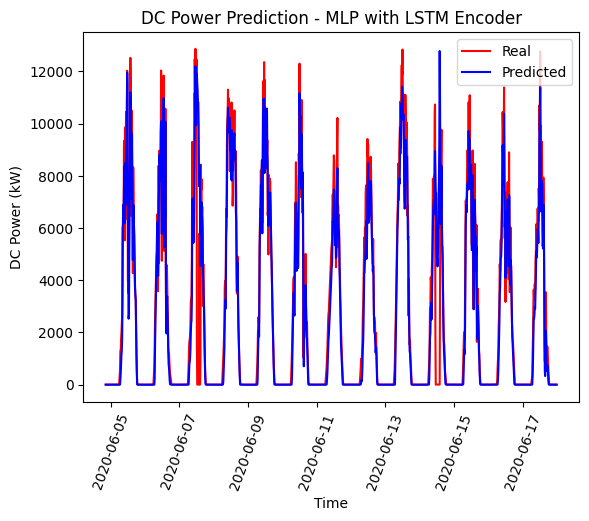

In [ ]:
# Visualize the results
plt.plot(scores['datetime'],scores['real DC'], color = 'red', label = 'Real')
plt.plot(scores['datetime'],scores['test_preds'], color = 'blue', label = 'Predicted')
plt.title('DC Power Prediction - MLP with LSTM Encoder')
plt.xticks(rotation=70)
plt.xlabel('Time')
plt.ylabel('DC Power (kW)')
plt.legend()
plt.show()

#CNN-LSTM

In [ ]:
X = []
Y = []
T = 1

In [ ]:
for i in range(T, X_train.shape[0]):
  x = X_train[i-T:i,:]
  X.append(x)
  y = X_train[i,:]
  Y.append(y)

In [ ]:
X,Y=np.array(X),np.array(Y)

In [ ]:
subseq = 1
X = X.reshape(X.shape[0],subseq,X.shape[1],X.shape[2])
X.shape

(1892, 1, 1, 3)

In [ ]:
def cnn_lstm():
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=14, kernel_size=1, activation="sigmoid",
                                     input_shape=(X.shape[2], X.shape[3]))))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(21, activation="tanh", return_sequences=True))
    model.add(LSTM(14, activation="tanh", return_sequences=True))
    model.add(LSTM(7, activation="tanh"))
    model.add(Dense(3, activation="sigmoid"))
    model.add(Dense(1))
    return model

In [ ]:
model = cnn_lstm()
opt = keras.optimizers.Adam(learning_rate=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model.compile(optimizer=opt, loss='mse')

In [ ]:
epochs = 100
batch = 16
history = model.fit(X, Y, epochs=epochs, batch_size=batch, validation_split=.1, callbacks=[early_stop], verbose=1).history


Epoch 1/100
107/107 [==============================] - 13s 22ms/step - loss: 0.0953 - val_loss: 0.0883
Epoch 2/100
107/107 [==============================] - 1s 8ms/step - loss: 0.0889 - val_loss: 0.0826
Epoch 3/100
107/107 [==============================] - 1s 9ms/step - loss: 0.0846 - val_loss: 0.0787
Epoch 4/100
107/107 [==============================] - 1s 11ms/step - loss: 0.0818 - val_loss: 0.0762
Epoch 5/100
107/107 [==============================] - 1s 11ms/step - loss: 0.0801 - val_loss: 0.0746
Epoch 6/100
107/107 [==============================] - 1s 10ms/step - loss: 0.0791 - val_loss: 0.0736
Epoch 7/100
107/107 [==============================] - 1s 10ms/step - loss: 0.0784 - val_loss: 0.0728
Epoch 8/100
107/107 [==============================] - 1s 8ms/step - loss: 0.0776 - val_loss: 0.0719
Epoch 9/100
107/107 [==============================] - 1s 9ms/step - loss: 0.0766 - val_loss: 0.0707
Epoch 10/100
107/107 [==============================] - 1s 8ms/step - loss: 0.0752 - 

In [ ]:
model.summary()

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_46 (TimeDi  (None, 1, 1, 14)         56        
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 1, 1, 14)         0         
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 1, 14)            0         
 stributed)                                                      
                                                                 
 lstm_217 (LSTM)             (None, 1, 21)             3024      
                                                                 
 lstm_218 (LSTM)             (None, 1, 14)             2016      
                                                     

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=[x for x in range(len(history['loss']))], y=history['loss'],
                    mode='lines',
                    name='train loss'))

fig.add_trace(go.Scatter(x=[x for x in range(len(history['val_loss']))], y=history['val_loss'],
                    mode='lines',
                    name='validation loss'))

fig.update_layout(title="CNN-LSTM Loss",
                  yaxis=dict(title="Loss"),
                  xaxis=dict(title="Epoch"))

fig.show()

In [ ]:
Xtt = []
Ytt = []
T = 1

In [ ]:
for i in range(T, X_test.shape[0]):
  x = X_test[i-T:i,:]
  Xtt.append(x)
  y = X_test[i,:]
  Ytt.append(y)

In [ ]:
Xtt,Ytt=np.array(Xtt),np.array(Ytt)

In [ ]:
Xtt.shape

(1260, 1, 3)

In [ ]:
Xtt = Xtt.reshape(Xtt.shape[0],subseq,Xtt.shape[1],Xtt.shape[2])

In [ ]:
X_pred = model.predict(Xtt)

40/40 [==============================] - 1s 3ms/step


In [ ]:
target = test[['DC_POWER']].values
target = target.reshape(target.shape[0],1)
sct = MinMaxScaler()
target = sct.fit_transform(target)

In [ ]:
testind = test.iloc[1:]

In [ ]:
X_pred = sct.inverse_transform(X_pred)
X_pred = pd.DataFrame(X_pred)
X_pred.index = testind.index

In [ ]:
X_pred['MODULE_TEMPERATURE'],X_pred['IRRADIATION'],X_pred['DC_POWER'] = test['MODULE_TEMPERATURE'],test['IRRADIATION'],test['DC_POWER']

In [ ]:
X_pred = X_pred.rename(columns={0: "test_preds"})

In [ ]:
scores = X_pred
scores['datetime'] = df_timestamp.loc[630:]
scores['real DC'] = scores['DC_POWER']
scores["loss_mae"] = (scores['real DC'] - scores['test_preds']).abs()

In [ ]:
# Three sigma way
mean = scores['loss_mae'].mean()
std = scores['loss_mae'].std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std
scores['Threshold'] = upper_bound
scores['Anomaly'] = np.where((scores['loss_mae'] < lower_bound) | (scores['loss_mae'] > upper_bound), 1, 0)

In [ ]:
scores.describe()

,test_preds,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,real DC,loss_mae,Threshold,Anomaly
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03,1260.000000
mean,2644.663330,29.636087,0.213857,2586.661481,2586.661481,819.191914,3.898899e+03,0.023016
std,3112.280762,11.066219,0.285984,3513.470837,3513.470837,1026.568876,4.549279e-13,0.150013
min,161.417603,18.140415,0.000000,0.000000,0.000000,2.842468,3.898899e+03,0.000000
25%,294.662773,20.840490,0.000000,0.000000,0.000000,273.634476,3.898899e+03,0.000000
50%,476.640488,23.130767,0.015325,60.857143,60.857143,360.236389,3.898899e+03,0.000000
75%,5256.130859,38.815374,0.424359,5203.142857,5203.142857,941.341143,3.898899e+03,0.000000
max,9632.855469,60.757050,1.221652,12864.285710,12864.285710,7826.714844,3.898899e+03,1.000000


In [ ]:
fig = go.Figure(data=[go.Histogram(x=scores['loss_mae'])])
fig.update_layout(title="Error distribution",
                 xaxis=dict(title="Error delta between predicted and real data [DC Power]"),
                 yaxis=dict(title="Data point counts"))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=scores['datetime'],
                         y=scores['loss_mae'],
                         name="Loss"))
fig.add_trace(go.Scatter(x=scores['datetime'],
                         y=scores['Threshold'],
                         name="Threshold"))

fig.update_layout(title="Error Timeseries and Threshold",
                 xaxis=dict(title="DateTime"),
                 yaxis=dict(title="Loss"))
fig.show()

In [ ]:
scores['Anomaly'].value_counts()

0    1231
1      29
Name: Anomaly, dtype: int64

In [ ]:
anomalies = scores[scores['Anomaly'] == 1][['real DC']]
anomalies = anomalies.rename(columns={'real DC':'anomalies'})
scores = scores.merge(anomalies, left_index=True, right_index=True, how='left')

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=scores["datetime"], y=scores["real DC"],
                    mode='lines',
                    name='DC Power'))

fig.add_trace(go.Scatter(x=scores["datetime"], y=scores["anomalies"],
                    name='Anomaly',
                    mode='markers',
                    marker=dict(color="red",
                                size=11,
                                line=dict(color="red",
                                          width=2))))

fig.update_layout(title_text="Anomalies Detected CNN-LSTM")

fig.show()

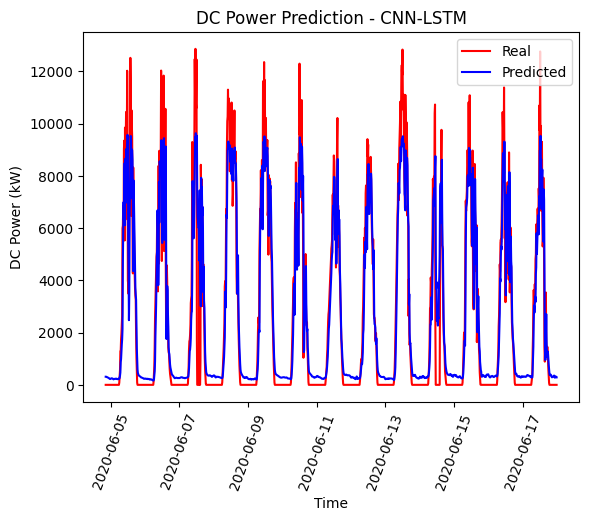

In [ ]:
# Visualize the results
plt.plot(scores['datetime'],scores['real DC'], color = 'red', label = 'Real')
plt.plot(scores['datetime'],scores['test_preds'], color = 'blue', label = 'Predicted')
plt.title('DC Power Prediction - CNN-LSTM')
plt.xticks(rotation=70)
plt.xlabel('Time')
plt.ylabel('DC Power (kW)')
plt.legend()
plt.show()